# King County Housing Analysis

---

**Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read data
df = pd.read_csv('data/kingcounty.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


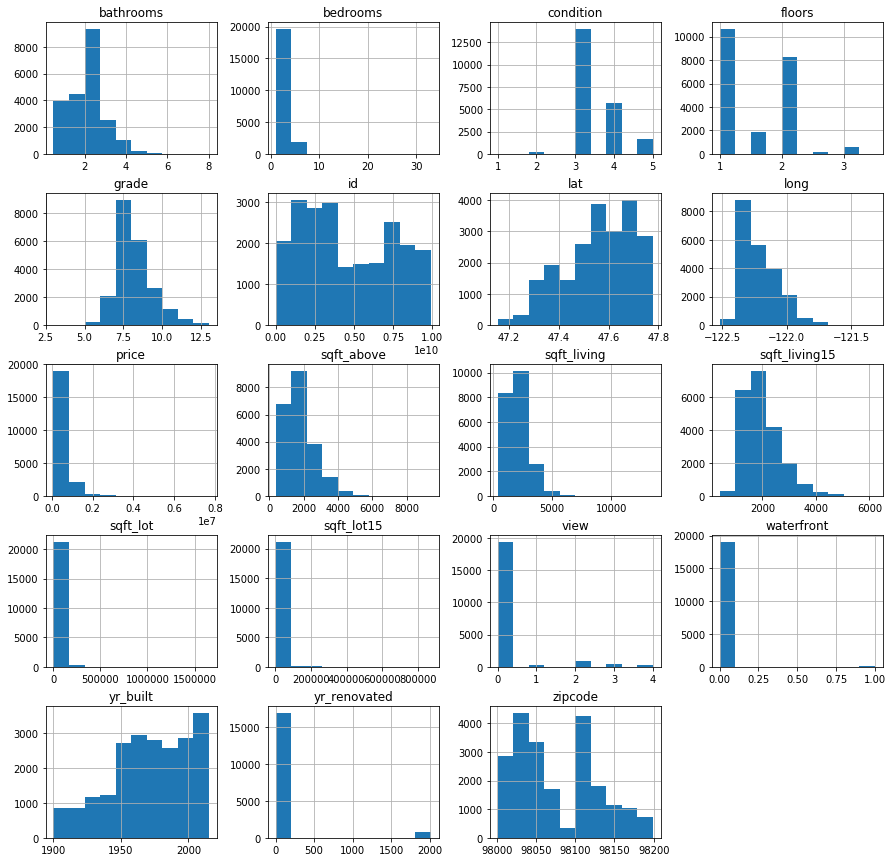

In [4]:
df.hist(figsize=(15,15));

---

## Data Cleaning

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
# waterfront, view, and yr_renovated have null values
# will look into that deeper to decide how to deal with them
# yr_renovated has a lot of missing values represented with a placeholder

In [7]:
# replace NaNs with 0
df['yr_renovated'] = df['yr_renovated'].fillna(0)

In [8]:
# make column renovated categorical, 1=renovated 0=not renovated
#drop yr_renovated column
df['renovated']=df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(['yr_renovated'], axis=1)

In [9]:
df['renovated'].value_counts()

0    20853
1      744
Name: renovated, dtype: int64

In [10]:
# #convert categorical data to dummie variable
# renovated_dummies = pd.get_dummies(df["renovated"], prefix="renovated")
# df = df.drop(["renovated"], axis=1)
# df = pd.concat([df, renovated_dummies], axis=1)

In [11]:
# replace NaN values in "waterfront" with 0
df['waterfront'] = df['waterfront'].fillna(0)

In [12]:
# I will replace NaN values in "view" with 0
df['view'] = df['view'].fillna(0)

In [13]:
#one last check
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
renovated        0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
renovated        21597 non-null int64
dtypes: float64(7), int64(12), object(2)
memory usage: 3.5+ MB


In [15]:
df.sqft_basement.value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

In [16]:
#replaced '?' values with difference in sqft_living and sqft_above
df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [17]:
#deal with object types in order to plot heatmap
df['sqft_basement'] = df['sqft_basement'].map(float)

In [18]:
#drop id column because it is not a predictor
df = df.drop(['id'], axis=1)

In [19]:
#change yr_built column to age of house column
df['age'] = df['yr_built'].apply(lambda x: 2019 - x)
df = df.drop(['yr_built'], axis=1)

In [20]:
# # dummie column for 'waterfront'
# waterfront_dummies = pd.get_dummies(df["waterfront"], prefix="waterfront")
# df = df.drop(["waterfront"], axis=1)
# df = pd.concat([df, waterfront_dummies], axis=1)

In [21]:
#create df_1 for use in heatmap
df_1 = df.drop(['date'], axis=1)

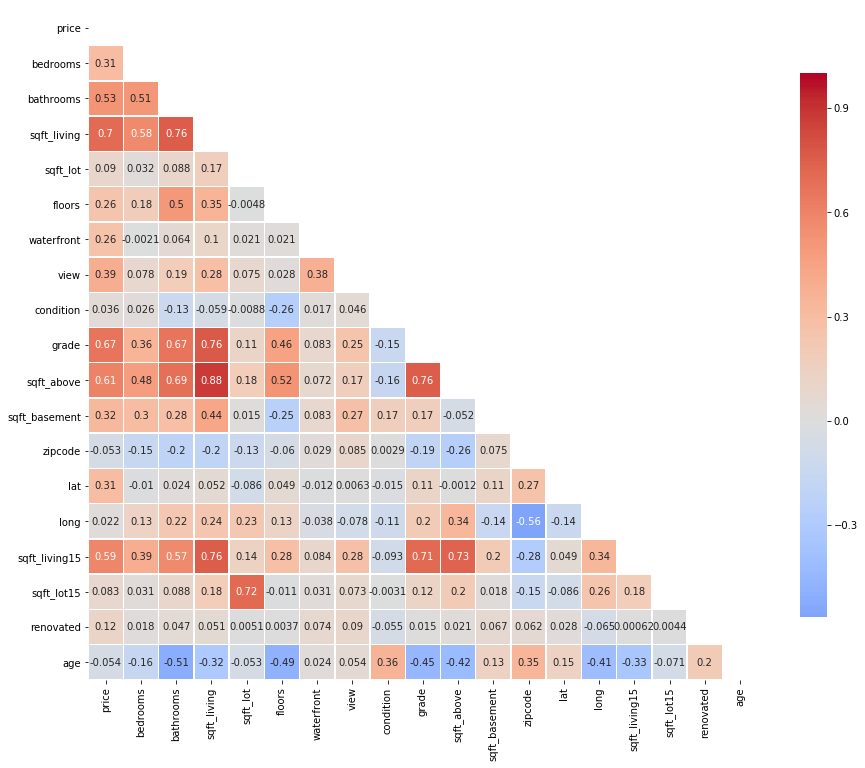

In [22]:
#visualize correlation using heatmap
corr = df_1.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

**Looks like 'age' and 'condition' are negatively correlated, <br/>
these two columns provide valuable info, <br/>
need to figure out how to deal with these two columns in order to use in predictive model** 

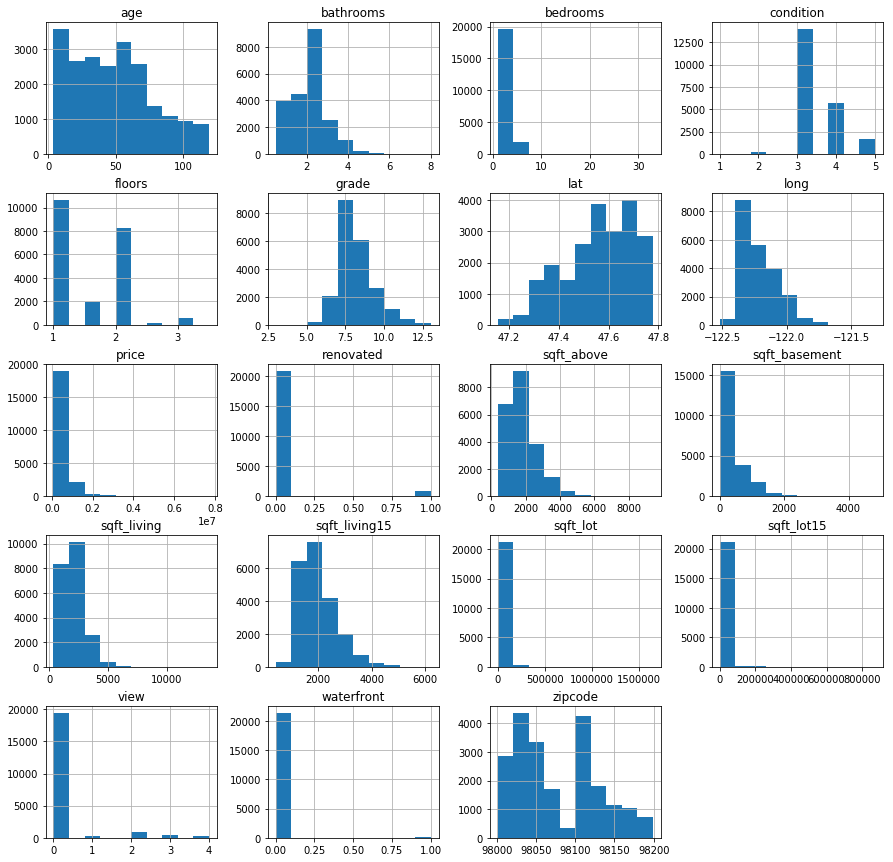

In [23]:
#let's take a look of distributions after preliminary data cleaning
df.hist(figsize=(15,15));

---

**Plot Joint Plots for better correlation visualization**

In [24]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', 'age'],
      dtype='object')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


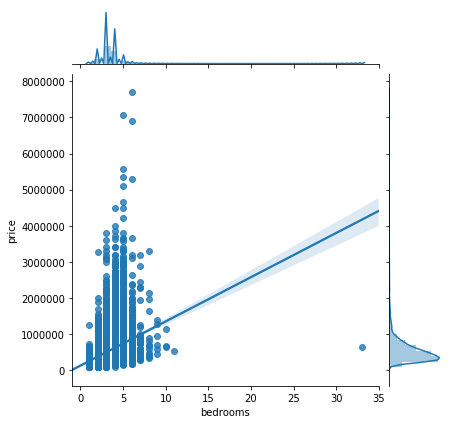

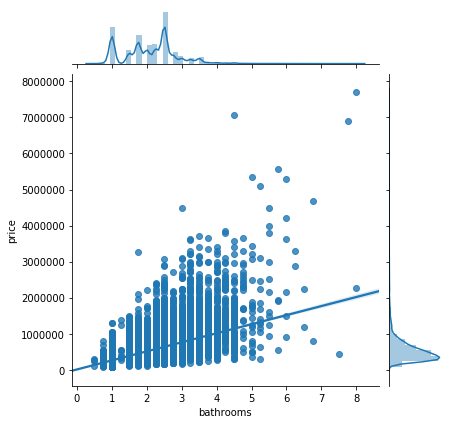

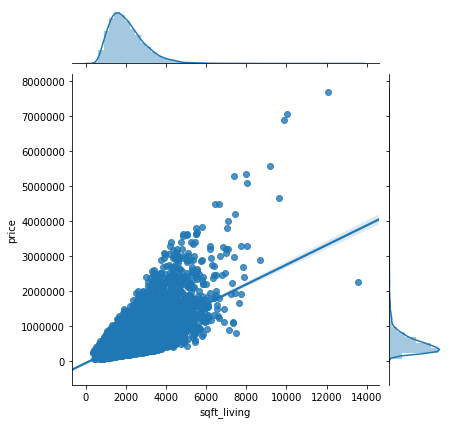

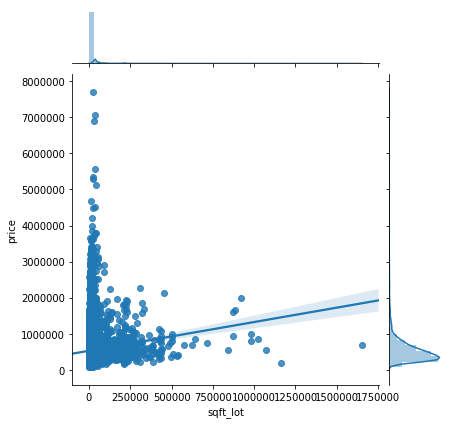

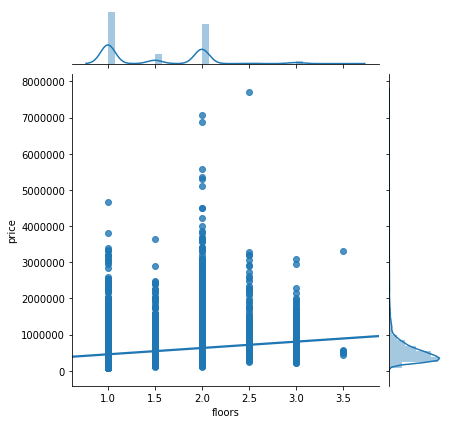

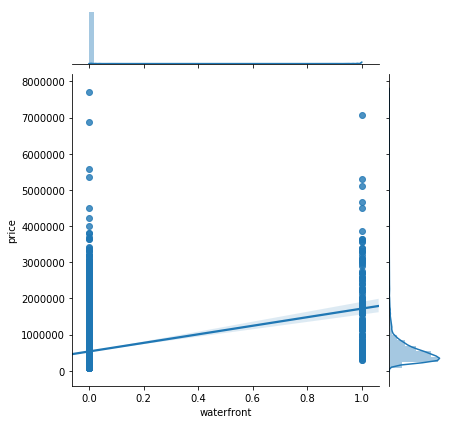

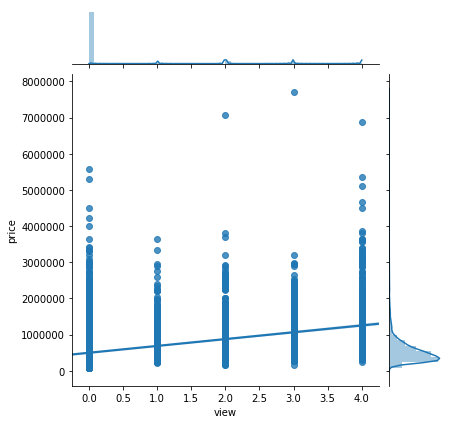

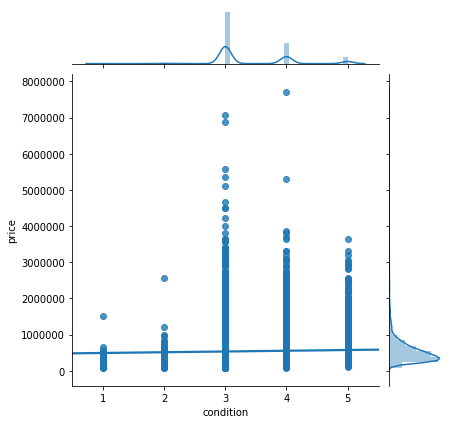

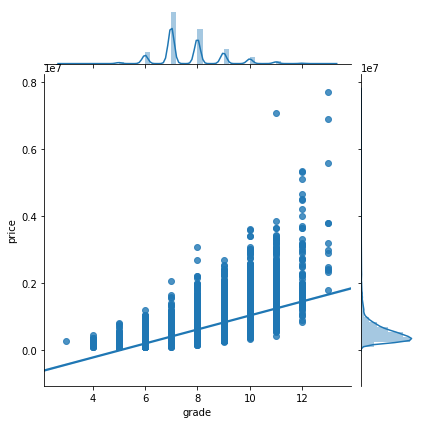

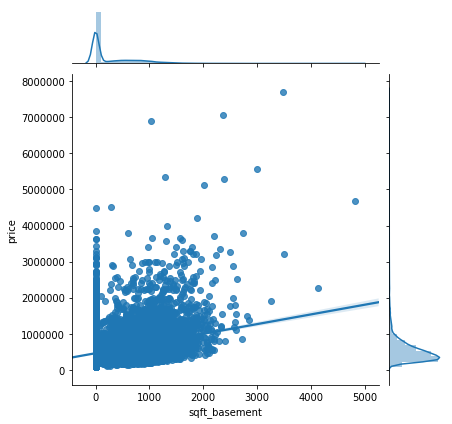

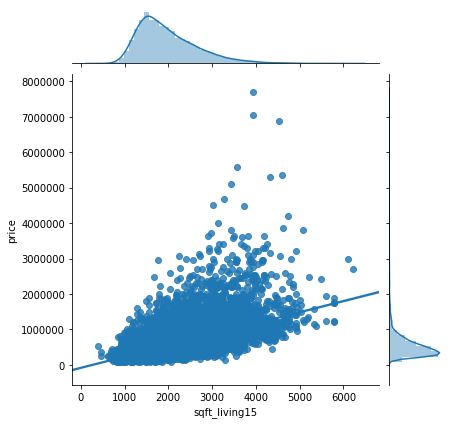

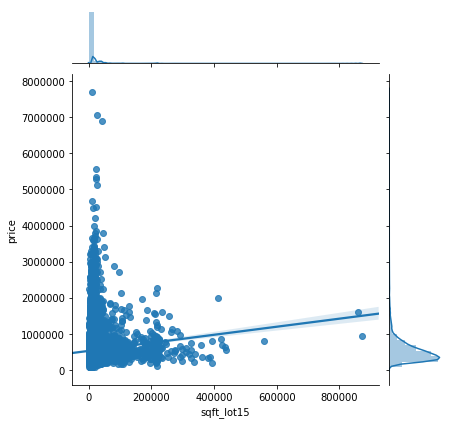

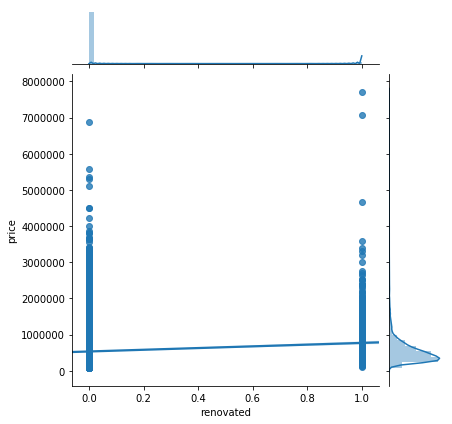

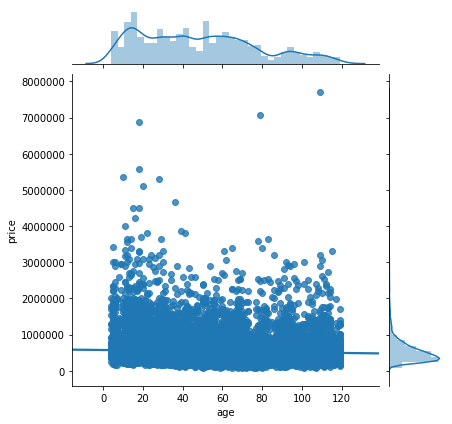

In [25]:
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
              'condition', 'grade', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'renovated',
             'age']

#plotting selected variables
for col in predictors:
    sns.jointplot(col,'price',data=df,kind='reg')
    plt.show()